In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import joblib
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常

In [2]:
data = pd.read_csv("E:\竞赛\服创赛-A08\data\process_data.csv")

In [3]:
# 原始数据集文件路径
# original_data_path = '/kaggle/working/欺诈手段特征集.xlsx'
original_data = data

# 其他文件的路径列表
other_files = ["E:\竞赛\服创赛-A08\data\ctgan\\add_data_2.csv"]

# 读取原始数据集
# original_data = pd.read_excel(original_data_path)

# 将原始数据集分割为训练集和测试集
train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)

# 初始化一个空的DataFrame来存储类别为1的样本
category_1_samples = pd.DataFrame()

# 遍历其他文件
for file in other_files:
    # 读取文件
    data = pd.read_csv(file)
    
    # 提取 RES 列为1的样本
    filtered_data = data[data['RES'] == 1]
    
    # 将这些样本添加到category_1_samples
    category_1_samples = pd.concat([category_1_samples, filtered_data], ignore_index=True)

# 将提取出的样本与训练集进行拼接
combined_train_data = pd.concat([train_data, category_1_samples], ignore_index=True)

# 如果需要保存合并后的训练集和测试集
combined_train_data.to_csv('E:\竞赛\服创赛-A08\\data\\ctgan\\combined_train_dataset.csv', index=False)
test_data.to_csv('E:\竞赛\服创赛-A08\\data\\ctgan\\test_dataset.csv', index=False)

In [4]:
data = pd.read_csv('E:\竞赛\服创赛-A08\\data\\ctgan\\combined_train_dataset.csv')
test = pd.read_csv('E:\竞赛\服创赛-A08\\data\\ctgan\\test_dataset.csv')

# 删除个人编码特征列
data = data.drop(['个人编码'], axis=1)
test = test.drop(['个人编码'], axis=1)
data.shape,test.shape

((18568, 81), (4800, 81))

In [5]:
# 计算类别1的样本数
count_class_1 = data[data["RES"] == 1].shape[0]
count_class_0 = data[data["RES"] == 0].shape[0]

# 打印类别1的样本数
print("类别1的样本数：", count_class_1)
print("类别0的样本数：", count_class_0)

类别1的样本数： 7924
类别0的样本数： 10644


In [6]:
# 分离两个类别的样本
class_0 = data[data['RES'] == 0]
class_1 = data[data['RES'] == 1]

# 随机删除class_0的样本直到数量与class_1相同
class_0_under = class_0.sample(count_class_1)
combined_train_data_balanced = pd.concat([class_0_under, class_1], axis=0)

# 混洗数据
data = combined_train_data_balanced.sample(frac=1).reset_index(drop=True)

In [7]:
# 计算类别1的样本数
count_class_1 = data[data["RES"] == 1].shape[0]
count_class_0 = data[data["RES"] == 0].shape[0]

# 打印类别1的样本数
print("类别1的样本数：", count_class_1)
print("类别0的样本数：", count_class_0)

类别1的样本数： 7924
类别0的样本数： 7924


In [8]:
# 定义要提取的特征列表
features_to_extract = [
    # '个人编码',
    '就诊次数_SUM',
    '药品在总金额中的占比',
    '个人支付的药品占比', 
    '检查总费用在总金额占比', 
    '治疗费用在总金额占比',
    '就诊的月数', 
    '月就诊天数_MAX', 
    '月就诊天数_AVG',
    '月就诊医院数_MAX', 
    '月就诊医院数_AVG',
    'RES'
]

# 提取特征
data = data[features_to_extract]
test = test[features_to_extract]

# 保存到新的文件中
output_file_path = 'E:\竞赛\服创赛-A08\\data\\ctgan\\fraud_trick.csv'  # 保存文件的路径和名称
data.to_csv(output_file_path, index=False)

print("文件已成功保存到", output_file_path)

文件已成功保存到 E:\竞赛\服创赛-A08\data\ctgan\fraud_trick.csv


In [9]:
data.head()

,就诊次数_SUM,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,治疗费用在总金额占比,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,RES
0,34,0.853894,0.001061,-0.000360,0.270968,4,8,4.891582,2,2.091848,1
1,52,0.929460,0.000524,0.024581,0.019977,6,9,8.166667,4,3.166667,0
2,97,0.958878,-0.001483,0.041135,0.017723,6,19,16.367600,3,1.747884,1
3,8,0.867332,0.000000,0.024696,0.020580,4,3,2.000000,2,1.250000,0
4,77,0.873594,0.030505,0.022378,0.044335,6,14,11.833333,3,2.333333,0


In [10]:
def strategy_4(model, X_test, y_test, thresholds):

    classification_reports = {}
    for thresh in thresholds:
        # 以概率形式获取预测结果
        y_probs = model.predict_proba(X_test)[:, 1]  # 获取正类的概率
        # 应用阈值
        y_pred_thresh = np.where(y_probs > thresh, 1, 0)
        # 生成并存储分类报告
        classification_reports[thresh] = classification_report(y_test, y_pred_thresh)

    return classification_reports

In [11]:
# 分离特征和目标变量
X = data.drop('RES', axis=1)
y = data['RES']

# 分离类别
data_majority = data[data.RES == 0]
data_minority = data[data.RES == 1]

X.shape

(15848, 10)

In [12]:
model = RandomForestClassifier(
    n_estimators=100,
    #max_depth=5,
    random_state=123,
    n_jobs=-1
)

In [13]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

# X_train.shape

In [14]:
model = model.fit(X,y)

In [15]:
# 分离特征和目标变量
X_test = test.drop('RES', axis=1)
y_test = test['RES']

In [16]:
thresholds = [ 0.5,0.55, 0.6,0.65, 0.7,0.75]
reports = strategy_4(model,X_test, y_test, thresholds)

# 输出每个阈值下的分类报告
for thresh, report in reports.items():
    print(f"Threshold: {thresh}\n", report)

Threshold: 0.5
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4563
           1       0.44      0.42      0.43       237

    accuracy                           0.95      4800
   macro avg       0.71      0.70      0.70      4800
weighted avg       0.94      0.95      0.94      4800

Threshold: 0.55
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      4563
           1       0.50      0.41      0.45       237

    accuracy                           0.95      4800
   macro avg       0.73      0.69      0.71      4800
weighted avg       0.95      0.95      0.95      4800

Threshold: 0.6
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      4563
           1       0.54      0.38      0.45       237

    accuracy                           0.95      4800
   macro avg       0.76      0.68      0.71      4800
weighted avg       0.95  

In [17]:
thresholds = [0.6]
reports = strategy_4(model,X_test, y_test,thresholds)
report

'              precision    recall  f1-score   support\n\n           0       0.96      0.99      0.98      4563\n           1       0.62      0.25      0.36       237\n\n    accuracy                           0.96      4800\n   macro avg       0.79      0.62      0.67      4800\nweighted avg       0.95      0.96      0.95      4800\n'

In [18]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 计算AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.8171233301061278


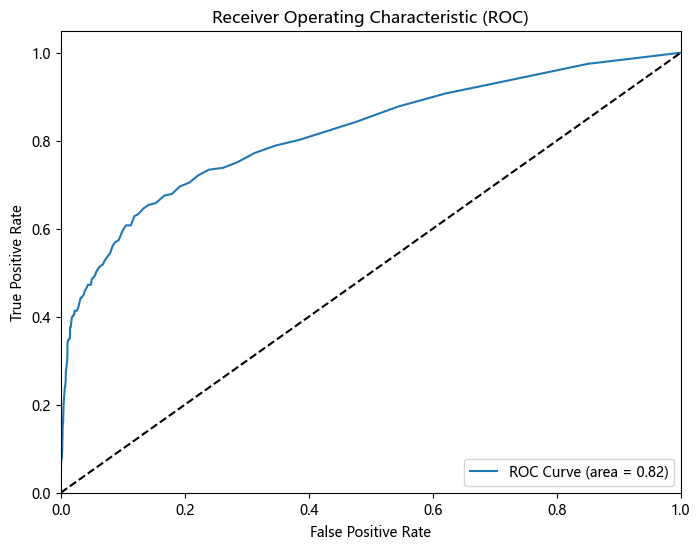

In [19]:
# 获取真正率（TPR）和假正率（FPR）以及阈值用于绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 随机概率的对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [20]:
# 评估模型在训练集上的性能

y_pred_proba = model.predict_proba(X)[:, 1]

# 计算AUC
auc = roc_auc_score(y, y_pred_proba)
print(f"AUC: {auc}")

AUC: 1.0


In [23]:
thresholds = [ 0.5,0.6]
reports = strategy_4(model,X, y, thresholds)

# 输出每个阈值下的分类报告
for thresh, report in reports.items():
    print(f"Threshold: {thresh}\n", report)

Threshold: 0.5
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7924
           1       1.00      1.00      1.00      7924

    accuracy                           1.00     15848
   macro avg       1.00      1.00      1.00     15848
weighted avg       1.00      1.00      1.00     15848

Threshold: 0.6
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7924
           1       1.00      1.00      1.00      7924

    accuracy                           1.00     15848
   macro avg       1.00      1.00      1.00     15848
weighted avg       1.00      1.00      1.00     15848



In [22]:
# 获取特征重要性
feature_importances = model.feature_importances_

# 排序特征重要性
sorted_idx = np.argsort(feature_importances)[::-1]

# 取出前二十个重要特征
top_20_features = np.array(X.columns)[sorted_idx][:20]

top_20_features

array(['就诊次数_SUM', '个人支付的药品占比', '月就诊天数_MAX', '月就诊医院数_AVG', '检查总费用在总金额占比',
       '月就诊天数_AVG', '治疗费用在总金额占比', '就诊的月数', '药品在总金额中的占比', '月就诊医院数_MAX'],
      dtype=object)